# Сравнение различных алгоритмов для разделение кластеров

### Загрузка сшитых обрезанных изображений

In [1]:
from img_with_bw_boundaries import *
# Загрузка изображений после предобработки
from load_imgs_from_folder import *
imgs_names, imgs = load_images_from_folder(r'tiled_data', ['Stitched_cropped_preprocessed', 'BW_nuclei'], '*.tif')
print(imgs_names)
I_nuclei = imgs[0][3]
BW_nuclei_initial = np.array(imgs[1][3], dtype=bool)

[['pano_CD3e.tif', 'pano_CD4.tif', 'pano_CD8.tif', 'pano_DAPI.tif', 'pano_Ki67.tif', 'pano_Membrane_summary.tif'], ['BW_nuclei_chan_vese.tif', 'BW_nuclei_GAC.tif', 'BW_nuclei_isodata.tif', 'BW_nuclei_local.tif', 'BW_nuclei_mean.tif', 'BW_nuclei_minimum.tif', 'BW_nuclei_niblack.tif', 'BW_nuclei_otsu.tif', 'BW_nuclei_sauvola.tif', 'BW_nuclei_triangle.tif', 'BW_nuclei_yen.tif']]


## Watershed и Random-walker

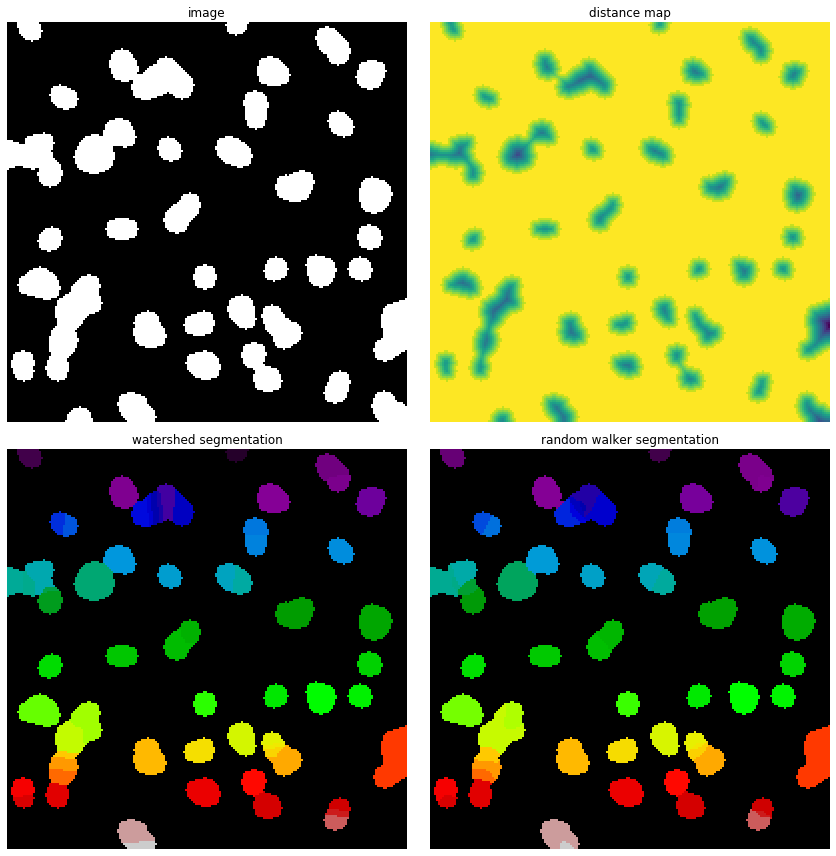

In [2]:
import numpy as np
from skimage.morphology import watershed, disk, binary_opening, remove_small_holes, remove_small_objects
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.segmentation import random_walker
import matplotlib.pyplot as plt
from scipy import ndimage

# Generate an initial image with two overlapping circles
# x, y = np.indices((80, 80))
# x1, y1, x2, y2 = 28, 28, 44, 52
# r1, r2 = 16, 20
# mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
# mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2

image = BW_nuclei_initial[400:600, 400:600]
se = disk(radius=5)
image = binary_opening(remove_small_holes(remove_small_objects(image, 30), 50), se)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

markers[~image] = -1
labels_rw = random_walker(image, markers)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('image')
plt.subplot(222)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.title('distance map')
plt.subplot(223)
plt.imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.title('watershed segmentation')
plt.subplot(224)
plt.imshow(labels_rw, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.title('random walker segmentation')

plt.tight_layout()
plt.show()

## Другой подход к Watershed

C:\Users\denni\YandexDisk\Python\BostonGene Contest\imshowpair.py:39: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  tic.tick1On = tic.tick2On = False
C:\Users\denni\YandexDisk\Python\BostonGene Contest\imshowpair.py:39: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  tic.tick1On = tic.tick2On = False
C:\Users\denni\YandexDisk\Python\BostonGene Contest\imshowpair.py:41: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  tic.tick1On = tic.tick2On = False
C:\Users\denni\YandexDisk\Python\BostonGene Contest\imshowpair.py:41: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


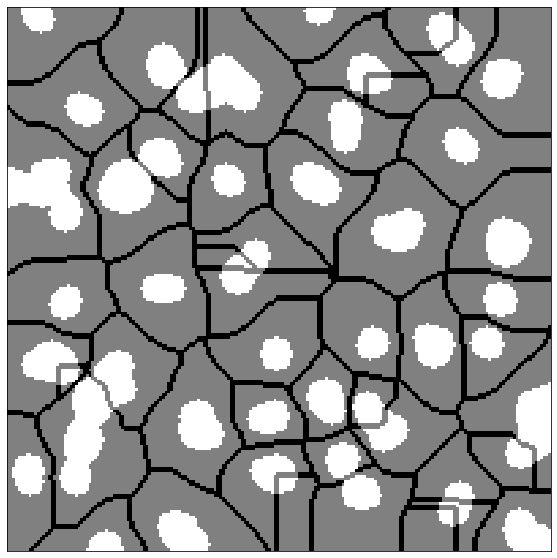

In [3]:
from skimage.morphology import h_minima, watershed
from skimage.morphology import (disk, binary_opening, binary_erosion, binary_dilation, remove_small_objects, remove_small_holes)
from scipy import ndimage
from skimage.segmentation import find_boundaries
from skimage.color import label2rgb

bw = BW_nuclei_initial[400:600, 400:600]
se = disk(radius=5)
bw = binary_opening(remove_small_holes(remove_small_objects(bw, 30), 50), se)

L = watershed(np.uint8(bw)) # Полная лажа

import cv2
# D = -ndimage.distance_transform_edt(~bw, return_distances=True) #лажа, а не преобразование
D = -cv2.distanceTransform(np.uint8(bw), cv2.DIST_C, 0)
L2 = watershed(D)

f, ax = plt.subplots(figsize=(10, 10)) 
ax.imshow(find_boundaries(L2), cmap='jet')

mask = h_minima(D, 2)
from imshowpair import imshowpair
import utils as utils
imshowpair(np.uint8(image) * 128, np.uint8(mask) * 128, utils.blend, show_all=False, cmap='gray')

from imimposemin import imimposemin
D2 = imimposemin(D, mask);
Ld2 = watershed(D2)
bw3 = bw.copy()

imshowpair(bw3 * 128, ~find_boundaries(Ld2) * 128,
                     utils.blend, show_all=False, cmap='gray')

**Вывод** оба алгоритма позволяют разделить часть кластеров, но также приводят к разделению цельного ядра

## Алгоритм StarDist

In [4]:
from stardist.models import StarDist2D 

# prints a list of available models 
StarDist2D.from_pretrained() 

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')
# model = StarDist2D.from_pretrained('2D_paper_dsb2018')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


(-0.5, 199.5, 199.5, -0.5)

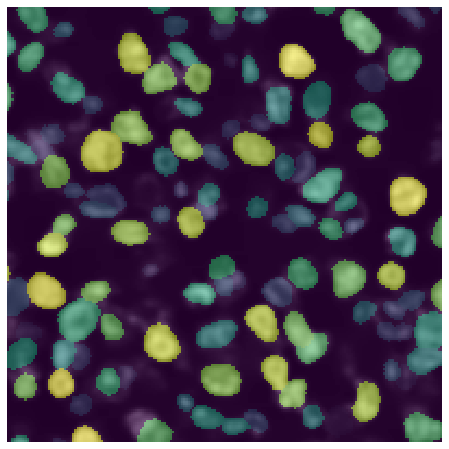

In [5]:
from csbdeep.utils import normalize

axis_norm = (0,1)

# Percentile-based image normalization
img = normalize(I_nuclei, 1,99.8, axis=axis_norm)

labels, details = model.predict_instances(img)

plt.figure(figsize=(8,8))
plt.imshow(img[400:600, 400:600], cmap='gray')
plt.imshow(labels[400:600, 400:600], alpha=0.5)
plt.axis('off')

### Ради интереса запустим на масках для разделения кластеров

(-0.5, 199.5, 199.5, -0.5)

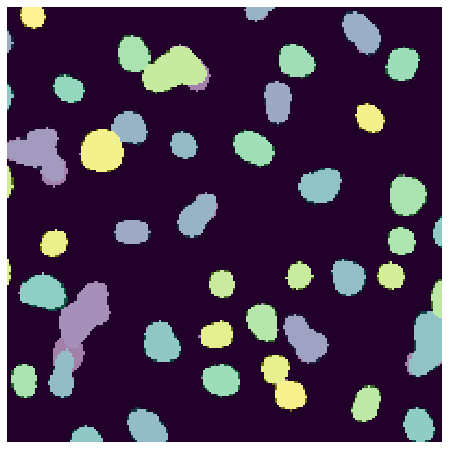

In [6]:
from csbdeep.utils import normalize

axis_norm = (0,1)

# Percentile-based image normalization
se = disk(radius=5)
img = normalize(binary_opening(remove_small_holes(remove_small_objects(BW_nuclei_initial, 30), 50), se), 1,99.8, axis=axis_norm)

labels, details = model.predict_instances(img)

plt.figure(figsize=(8,8))
plt.imshow(img[400:600, 400:600], cmap='gray')
plt.imshow(labels[400:600, 400:600], alpha=0.5)
plt.axis('off')

**Вывод** алгоритм водораздела и random walker приводят к разделению кластеров в некотором случае, однако также происходит разбиение единичных ядер. Алгоритм водораздела с некоторой модификацией приводит к получению меньшего числа ложных разбиений (в том числе кластеров), однако качесвто разбиения внутри кластеров неидеальное - местами не ставит границу. Алгоритм StarDist неплохо справляется с разделением кластеров, однако он не годится на данный момент для сегментации, требуется его переобучение. <br />
Соотвественно, новая идея: сохранить первые 200 объектов бинарной маски с использованием bounding box, вручную раскидать их по классам:кластер, одиночное ядро. Далее обучить классификатор (например, логистическую регрессию) по свойствам областей определять кластер или одиночное ядро. В случае если это кластер - передавать его на лэйбовку алгоритму StarDist

In [22]:
# Сохранение 200 объектов в папку BW_cluster_solo, предварительно очищаем границу
from skimage.measure import label, regionprops
from skimage.morphology import (disk, binary_opening, binary_erosion, binary_dilation, remove_small_objects, remove_small_holes)
from skimage.segmentation import clear_border
from save_imgs_to_folder import *

min_object_size = 100
max_hole_size = 50
se = disk(radius = 1)
BW_nuclei_cleared = clear_border(remove_small_holes(\
                                     remove_small_objects(\
                                             binary_opening(BW_nuclei_initial, se)\
                                     , min_object_size)\
                                     , max_hole_size)) # удаление мелких пустот и объектов, а также граничных элементов 
label_nuclei, l_num = label(BW_nuclei_cleared, return_num=True)
rp_nuclei = regionprops(label_image=label_nuclei, intensity_image=I_nuclei)

add_size = 10 # размер в пикселях для добавления черной рамки вокруг объекта

BW_objects = []
objects_names = []
file_ext = '.tif'

for i in range(1, 201):
    (min_row, min_col, max_row, max_col) = rp_nuclei[i - 1].bbox
    
    BW_object = (label_nuclei == i)
    BW_object = BW_object[min_row:max_row, min_col:max_col]
    
    BW_objects.append(np.pad(BW_object, pad_width=add_size, mode='constant', constant_values=False).astype(np.uint8) * 255)
    objects_names.append(str(i) + file_ext)
    
# save_imgs_to_folder(BW_objects, objects_names, r'tiled_data\BW_cluster_solo')

### Загрузка изображений и имен, создание общего csv файла с характеристиками и метками класса: кластер или одиночное ядро

In [7]:
from img_with_bw_boundaries import *
# Загрузка изображений после предобработки
from load_imgs_from_folder import *
names, imgs = load_images_from_folder(r'tiled_data\BW_cluster_solo', ['Solo', 'Cluster'], '*.tif')

solo, solo_names = imgs[0], names[0]
cluster, cluster_names = imgs[1], names[1]

In [8]:
import pandas as pd
from skimage.measure import label, regionprops

column_names = ['id', 'area', 'convex_area', 'eccentricity', 'equivalent_diameter',
                'euler_number', 'major_axis_length', #'feret_diameter_max', - в новой библиотеке только есть
                'minor_axis_length', 'perimeter', 'target']
indexes = range(1, len(solo_names) + len(cluster_names) + 1)
df = pd.DataFrame(index=indexes, columns=column_names) # Создание датафрейма, заполненного NaN
df.id = indexes

# возможно еще некоторые свойства могут оказаться информативными, target=0 - solo, 1 - cluster
for solo_img, solo_name in zip(solo, solo_names):
    solo_id = int(solo_name[:-4]) # удаление расширения и преобразование к индексу
    rp = regionprops(label_image=np.array(solo_img, dtype=np.uint8) + 1)[0]
    df.iloc[solo_id - 1, 1:] = [rp.area, rp.convex_area, rp.eccentricity, rp.equivalent_diameter,
                rp.euler_number, rp.major_axis_length, # rp.feret_diameter_max,
                rp.minor_axis_length, rp.perimeter, 0]
    
for cluster_img, cluster_name in zip(cluster, cluster_names):
    cluster_id = int(cluster_name[:-4]) # удаление расширения и преобразование к индексу
    rp = regionprops(label_image=np.array(cluster_img, dtype=np.uint8) + 1)[0]
    df.iloc[cluster_id - 1, 1:] = [rp.area, rp.convex_area, rp.eccentricity, rp.equivalent_diameter,
                rp.euler_number, rp.major_axis_length, # rp.feret_diameter_max,
                rp.minor_axis_length, rp.perimeter, 1]
df.to_csv(r'tiled_data\BW_cluster_solo\summary.csv', index=False)   

In [9]:
# Нормализация входных изображений
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = df.iloc[:, 1:-1]
scaler.fit(data)
data_scaled = scaler.transform(data)
df.iloc[:, 1:-1] = data_scaled

In [10]:
df.head(300)

,id,area,convex_area,eccentricity,equivalent_diameter,euler_number,major_axis_length,minor_axis_length,perimeter,target
1,1,0.040991,0.040573,0.180511,0.367477,0.0,0.342196,0.434361,0.214355,1
2,2,-0.210708,-0.214825,1.024134,-0.318216,0.0,-0.216657,-0.374753,-0.273077,1
3,3,-0.289658,-0.305024,-0.354022,-0.619398,0.0,-0.697848,-0.663688,-0.446791,0
4,4,0.322636,0.352594,-0.767906,0.930887,0.0,0.825999,1.211772,0.832783,1
5,5,-0.282604,-0.294593,-2.253705,-0.589167,0.0,-0.682557,-0.548603,-0.424770,0
...,...,...,...,...,...,...,...,...,...,...
196,196,-0.294113,-0.308501,-0.013552,-0.638934,0.0,-0.694808,-0.694208,-0.456768,0
197,197,-0.154280,-0.148567,-0.148395,-0.138114,0.0,-0.123396,-0.023095,-0.112799,1
198,198,-0.283718,-0.294991,-0.095793,-0.593886,0.0,-0.630121,-0.611449,-0.425900,0
199,199,0.083064,0.082593,0.986312,0.460989,0.0,0.557938,0.395262,0.160175,1


In [11]:
# Проверка на сбалансированность классов
print('0: ', df[df['target'] == 0].shape[0])
print('1: ', df[df['target'] == 1].shape[0])

0:  81
1:  119


Данные слегка несбалансированы, проведем балансировку с отбрасыванием избытка, хотя можно и дублированием элементов малочисленного класса

In [14]:
import pandas as pd
import numpy as np
np.random.seed(10)

df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

if df_0.size < df_1.size:
    remove_n = df_1.index.size - df_0.index.size
    drop_indices = np.random.choice(a=df_1.index, size=remove_n, replace=False)
    df_1 = df_1.drop(drop_indices)
    
if df_0.size > df_1.size:
    remove_n = df_0.index.size - df_1.index.size
    print(df_0.size, df_1.size, remove_n)
    drop_indices = np.random.choice(a=df_0.index, size=remove_n, replace=False)
    df_0 = df_0.drop(drop_indices)

print(df_0.shape[0], df_1.shape[0])    
df = pd.concat((df_0, df_1))
df = df.sample(frac=1).reset_index(drop=True)

81 81


In [15]:
X = df.iloc[:, 1:-1].values
y = np.uint8(df['target'].values)

## Логистическая регрессия

In [16]:
from sklearn import model_selection, linear_model, metrics
log_regressor = linear_model.LogisticRegression(class_weight='balanced')
cv_strategy = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
scores = model_selection.cross_val_score(log_regressor, X, y, cv = cv_strategy, scoring='f1', n_jobs=-1)
print(np.mean(scores))

0.9194243604004448


## Полиномиальные признаки (спрямляющие пространства)

In [17]:
from sklearn.preprocessing import PolynomialFeatures
"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(3)
"""Обучаем преобразование на обучающей выборке, применяем его к тестовой"""
X_poly = transform.fit_transform(X)

log_regressor_poly = linear_model.LogisticRegression(class_weight='balanced')
cv_strategy = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
scores = model_selection.cross_val_score(log_regressor_poly, X_poly, y, cv = cv_strategy, scoring='f1', n_jobs=-1)
print(np.mean(scores))

0.9239506172839506


## Balanced Random Forest

In [18]:
from imblearn.ensemble import BalancedRandomForestClassifier

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle=True)
brf = BalancedRandomForestClassifier(n_jobs=-1, warm_start=True, oob_score=True)
brf = brf.fit(X_train,y_train)
cv_strategy = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
scores = model_selection.cross_val_score(brf, X, y, cv = cv_strategy, scoring='f1', n_jobs=-1)
print(np.mean(scores))

Using TensorFlow backend.


0.9237488002193884


In [19]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# base_es = DecisionTreeClassifier(max_depth=10)
rb = RUSBoostClassifier(random_state=0)#base_estimator=base_es, n_estimators=100, random_state=0)
cv_strategy = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
scores = model_selection.cross_val_score(rb, X, y, cv = cv_strategy, scoring='f1', n_jobs=-1)
print(np.mean(scores))

0.8899317302678647


**Вывод** логистическая регрессия с полиномиальными признаками справилась лучше, стоило еще вначале посмотреть, может есть скоррелированные признаки, но изначально при их выборе учитывалось, что они должны быть слабо скоррелированы (в идеале независимыми)

In [20]:
log_regressor_poly = linear_model.LogisticRegression(class_weight='balanced')
log_regressor_poly.fit(X_poly, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Далее будем использовать классификатор для создания маски, содержащей только кластеры

In [23]:
BW_cluster = np.zeros(BW_nuclei_cleared.shape, dtype=bool)
BW_solo = np.zeros(BW_nuclei_cleared.shape, dtype=bool)
for i in range(1, l_num + 1):    
    BW_object = (label_nuclei == i) # использование лэйблов из BW_nuclei_cleared
    
    rp = regionprops(label_image=np.array(solo_img, dtype=np.uint8) + 1)[0]
    X_tmp = [rp.area, rp.convex_area, rp.eccentricity, rp.equivalent_diameter,
                rp.euler_number, rp.major_axis_length, # rp.feret_diameter_max,
                rp.minor_axis_length, rp.perimeter]
    y_tmp = log_regressor_poly.predict(transform.fit_transform(np.expand_dims(X_tmp, axis=0)))
    if y_tmp: #кластер
        BW_cluster |= BW_object
    else:
        BW_solo |= BW_object

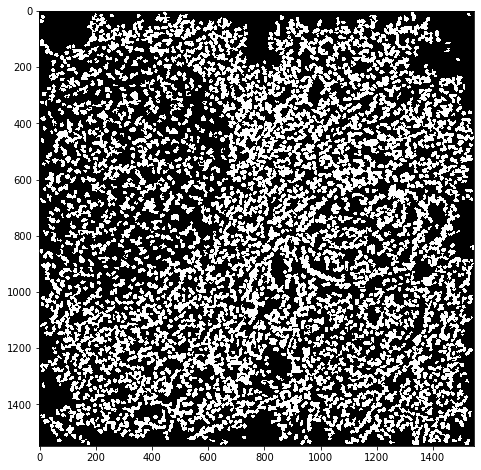

In [24]:
# Маска кластеров
plt.figure(figsize=(8,8))
plt.imshow(BW_cluster, cmap='gray')

In [25]:
from csbdeep.utils import normalize
axis_norm = (0,1)
# Percentile-based image normalization
BW_cluster_normalized = normalize(BW_cluster, 1,99.8, axis=axis_norm)
I_nuclei_normalized = normalize(I_nuclei, 1,99.8, axis=axis_norm)
label_cluster, _ = model.predict_instances(I_nuclei_normalized) 

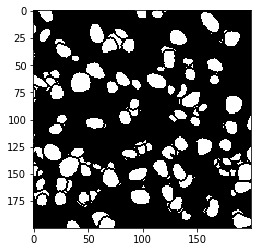

In [26]:
from skimage.segmentation import find_boundaries
BW_cluster_unclustered = BW_cluster & ~find_boundaries(label_cluster, connectivity=1, mode='thick', background=0)
plt.imshow(BW_cluster_unclustered[400:600, 400:600], cmap='gray')

Видно, что в результате сегментации кластеров образовались мелки объекты, удалим их с помощью фильтрации по размеру

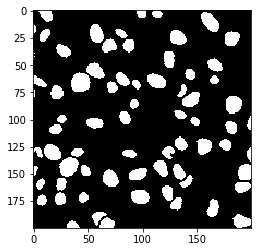

In [27]:
min_object_size = 50 # подобран исходя из адекватности удаления областей
se = disk(radius = 1)
BW_cluster_unclustered_cleared = remove_small_objects(binary_opening(BW_cluster_unclustered, se), min_object_size) # удаление мелких пустот и объектов, а также граничных элементов 
plt.imshow(BW_cluster_unclustered_cleared[400:600, 400:600], cmap='gray')

In [28]:
# Объединяем маски кластеров и отдельных ядер
BW_summary = BW_cluster_unclustered_cleared | BW_solo # они гарантировано не пересекаются

In [29]:
# Сохранение файла маски ядер
save_imgs_to_folder([np.array(BW_summary, dtype=np.uint8) * 255], ['BW_summary_Stardist_from_I_nuclei.tif'], r'tiled_data\BW_cluster_solo')

# Интересные статьи по разделению кластеров
* https://hal.archives-ouvertes.fr/hal-01918408/file/LachaizeIJAR18.pdf
* https://www-ist.massey.ac.nz/dbailey/sprg/pdfs/1992_NZIPW_195.pdf
* https://www.programmersought.com/article/70585879013/
* https://github.com/stardist/stardist